In [1]:
#@title Download the test files
#@markdown If you already have some pdf or epub create the "Book" folder and upload them inside

!mkdir Book
%cd Book
!curl -L -o 'Frankenstein.pdf' 'https://docs.google.com/uc?export=download&id=1I9FCA6BCfIBI2a0Mj27DQpCt7RReA6SZ'
!curl -L -o 'Pride andPrejudice.pdf' 'https://docs.google.com/uc?export=download&id=1bXLFI5fPZ9NbpBfMGwAzrLC0Z1JWwLFl'
!curl -L -o 'Moby Dick.pdf' 'https://docs.google.com/uc?export=download&id=0BzNKPQAbLg3ST1Z3TGRDTWgyazQ'
!curl -L -o 'Romeo and Juliet.pdf' 'https://docs.google.com/uc?export=download&id=1xLJ7l3p9xfoWkKYW0SrpPjX2gzyzAbAc'
!curl -L -o '1984.pdf' 'https://docs.google.com/uc?export=download&id=0B7YdufHI7qjeOF83X1lldnkwcUk'
!curl -L -o 'Jane Eyre.pdf' 'https://docs.google.com/uc?export=download&id=0ByDNp1moOBkFTWlmQUlORWwwWmc'
!curl -L -o 'Brave New World.pdf' 'https://docs.google.com/uc?export=download&id=0B2ER-JC3cRxsMkt3V2MxTEZGbnlWZ3o2UG85SjV4TV9nNVI4'
%cd ..

/content/Book
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  932k  100  932k    0     0   301k      0  0:00:03  0:00:03 --:--:--  532k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1576k  100 1576k    0     0   328k      0  0:00:04  0:00:04 --:--:--  470k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  405k  100  405k    0     0  95518      0  0:00:04  0:00:04 --:--:--  117k
  % Total    % Received % Xferd  Avera

In [2]:
# @title Install dependencies
!pip install ebooklib
!pip install PyPDF2
!pip install pdf2image
!sudo apt-get install poppler-utils
!wget https://github.com/googlefonts/RobotoMono/raw/refs/heads/main/fonts/ttf/RobotoMono-Bold.ttf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.5/115.5 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ebooklib: filename=EbookLib-0.18-py3-none-any.whl size=38778 sha256=07c187e6b7bc4e0ec438d4955be0c17b405937f986c499d83b6bb313d9076add
  Stored in directory: /root/.cache/pip/wheels/0f/38/cc/a3728bb72a315d9d8766fb71d362136372066fc25ad838f8fa
Successfully built ebooklib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 0s (958 kB/s)
debconf: unable to initialize frontend: Di

100%|██████████| 7/7 [00:00<00:00,  9.99it/s]


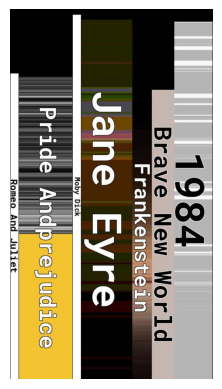

In [9]:
import ebooklib
from ebooklib import epub
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import numpy
import glob
import os
from PyPDF2 import PdfReader
import random
import json
from tqdm import tqdm
import tempfile
from pdf2image import convert_from_path

blacklist = []
base_path = "/content/Book"

if not os.path.exists("pdf"):
    os.makedirs("pdf")

def get_cover(filename):
    with tempfile.TemporaryDirectory() as path:
        images_from_path = convert_from_path(filename, output_folder=path, last_page=1, first_page =0)

    base_filename  =  os.path.splitext(os.path.basename(filename))[0] + '.jpg'

    for page in images_from_path:
        ret = os.path.join("pdf", base_filename)
        page.save(ret, 'JPEG')
        return ret

def diff(a,b):
    if a > b:
        return a - b
    else:
        return b -a

def type_text(image1, text, px, py, color, shadowcolor, rotate):
    imgw, imgh = image1.size
    for i in range(1,100):
        font = ImageFont.truetype('RobotoMono-Bold.ttf', i)
        bbox = font.getbbox(text)
        width, height = bbox[2] - bbox[0], bbox[3] - bbox[1]
        #print(str(width)+" > "+str(imgh)+" or "+str(height)+" > "+str(imgw))
        if width > imgh or height > imgw:
            font = ImageFont.truetype('RobotoMono-Bold.ttf', int(i * 0.8))
            bbox = font.getbbox(text)
            width, height = bbox[2] - bbox[0], bbox[3] - bbox[1]
            break

    image2 = Image.new('RGBA', (imgh, imgw), (0, 0, 0, 0))
    draw2 = ImageDraw.Draw(image2)
    imgw, imgh = image1.size

    x = int(diff(imgh,width)/2)
    y = int(diff(imgw,height)/2) - int(i / 4)

    #################SHADOW#################
    draw2.text((x-1, y-1), text, font=font, fill=shadowcolor)
    draw2.text((x+1, y-1), text, font=font, fill=shadowcolor)
    draw2.text((x-1, y+1), text, font=font, fill=shadowcolor)
    draw2.text((x+1, y+1), text, font=font, fill=shadowcolor)
    #################SHADOW#################

    draw2.text((x, y), text=text, font=font, fill=color)
    image2 = image2.rotate(rotate, expand=1)

    sx, sy = image2.size
    image1.paste(image2, (px, py, px + sx, py + sy), image2)
    return image1

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def avg_col(ar):
    summ = 0
    cont = 0
    for a in ar:
        summ += (int(a[0][0]) + int(a[0][1]) + int(a[0][2]))/3
        cont += 1
    return summ / cont

def img_resize_from_h(img, new_height):
    width, height = img.size
    new_width = int((width / height) * new_height)
    img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
    return img

def is_close_to_white(image, threshold=240):
    """
    Verifica se l'immagine è prevalentemente bianca.
    :param image: L'immagine da controllare.
    :param threshold: Il valore sopra il quale i pixel sono considerati bianchi.
    :return: True se l'immagine è prevalentemente bianca, False altrimenti.
    """
    pixels = image.load()
    width, height = image.size
    for y in range(height):
        for x in range(width):
            r, g, b = pixels[x, y]
            if r < threshold or g < threshold or b < threshold:
                return False
    return True

def add_border_if_white(image_path):
    # Apri l'immagine
    image = Image.open(image_path)
    width, height = image.size

    # Modifica l'immagine se è prevalentemente bianca
    if is_close_to_white(image):
        # Crea una nuova immagine con le colonne nere aggiunte
        new_width = width + 2
        new_image = Image.new('RGB', (new_width, height), (255, 255, 255))
        new_pixels = new_image.load()

        # Copia i pixel dell'immagine originale nella nuova immagine
        original_pixels = image.load()
        for y in range(height):
            for x in range(width):
                new_pixels[x + 1, y] = original_pixels[x, y]

        # Aggiungi le colonne nere all'inizio e alla fine
        for y in range(height):
            new_pixels[0, y] = (0, 0, 0)  # Prima colonna nera
            new_pixels[new_width - 1, y] = (0, 0, 0)  # Ultima colonna nera

        return new_image
    else:
        # Restituisci l'immagine originale se non è prevalentemente bianca
        return image

pdf_files = glob.glob(base_path + "/*.pdf")
epub_files = glob.glob(base_path + "/*.epub")
all_files = sorted(pdf_files + epub_files)

counter = 0
cm2px = 37.7952755906
result = Image.new('RGB', (1, int(24 * cm2px)))
for file in tqdm(all_files):
    skip = False
    for blackword in blacklist:
        if blackword in file.lower():
            skip = True
    if skip:
        continue

    txt_file = "pdf/" + os.path.basename(file).replace(".epub", ".txt").replace(".pdf", ".txt")
    book_file = txt_file.replace(".txt", ".jpg")
    if not os.path.isfile(txt_file):
        print(file)

        if ".epub" in file:
            pdf_file = "pdf/" + os.path.basename(file).replace("epub", "pdf")
            os.system('ebook-convert "'+file+'" '+'"'+pdf_file+'"')

            book = epub.read_epub(file)
            title = book.get_metadata('DC', 'title')[0][0]
        if ".pdf" in file:
            pdf_file = file
            title = file.replace(".pdf","")

        print(pdf_file)
        pdf = PdfReader(open(pdf_file,'rb'))
        pages = len(pdf.pages)
        cm = pages * 0.0072
        print(str(pages)+" pages "+str(cm)+" cm")

        #create image
        img = Image.open(get_cover(pdf_file))
        img = img_resize_from_h(img, random.randint(int(18 * cm2px), int(24 * cm2px)))
        pix = numpy.array(img)
        #get first column
        col = pix[:,:1,:]

        new_im = Image.fromarray(col)
        new_line = Image.fromarray(col)
        px = int(cm * cm2px)

        for i in range(px):
            new_im = get_concat_h(new_im, new_line)

        #get color text
        bg_col = avg_col(col)
        if bg_col > (255/2):
            txt_col = (0, 0, 0)
            shadowcolor = (255, 255, 255)
        else:
            txt_col = (255, 255, 255)
            shadowcolor = (0, 0, 0)

        #insert title text
        title = os.path.basename(title).replace("(Italian Edition)","").strip()
        title = title.split(":")[0].strip()
        title = title.split("(")[0].strip()

        f = open(txt_file,"w")
        f.write(json.dumps({"title": title, "txt_col": txt_col, "shadowcolor": shadowcolor}))
        f.close()

        new_im.save(book_file)
    else:
        f = open(txt_file,"r")
        data = json.loads(f.read())
        f.close()

        title = data["title"]
        txt_col = tuple(data["txt_col"])
        shadowcolor = tuple(data["shadowcolor"])

        #new_im = Image.open(book_file)
        new_im = add_border_if_white(book_file)

    new_im = type_text(new_im, title.title(), 0, 0, txt_col, shadowcolor, 90)

    #new_im.save('pillow_concat_h.jpg')

    result = get_concat_h(result, new_im)
    result.save('result.jpg')

    counter += 1

#elimina file nella cartella pdf
files = glob.glob('pdf/*.pdf')
for f in files:
    os.remove(f)

import matplotlib.pyplot as plt
img = Image.open('result.jpg')
img = img.rotate(180)
plt.imshow(img)
plt.axis('off')
plt.show()
